# 极化密度模拟

## 输入库

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import shutil
#import matplotlib.gridspec as gridspec

## 变量

In [2]:
TotalSimTime = 100.0
MaxStep = 10000000
DiagTime = 0.1
dt = 0.1
Nv = 64
Nxi = 32
vMax = 4.0
lambdaS = 2.0

'Field'
deltaE = 0.1
omegaE = 0.05
gammaE = 0.3
deltaI = 0.1
omegaI = 0.7
gammaI = 0.3

kS = 2.0*np.pi/lambdaS

In [3]:
global_list = ['deltaE','omegaE','gammaE','deltaI','omegaI','gammaI','kS']
for var_name in global_list:
  globals()[var_name] = globals().get(var_name,None)

## 功能函数

### 麦克斯韦分布

In [4]:
def FM(v):
  return np.exp(-0.5*(v*v))/(2.0*np.pi)

### 外部电场

In [5]:
def deltaEne(t):
  return deltaEneE(t) + deltaEneI(t)

def deltaEneE(t):
  return deltaE*(1.0-np.exp(-gammaE*t))*np.exp(-1j*omegaE*t)

def deltaEneI(t):
  return deltaI*(1.0-np.exp(-gammaI*t))*np.exp(-1j*omegaI*t)

### 线性部分

In [6]:
def DdfkDt(t,dt,hxi,Vv,Vcosxi,F0,dfk):
  DdfkDxi = np.zeros_like(dfk,dtype=np.complex128)
  h = 0.5*hxi
  DdfkDxi[1:-1,:] = (dfk[2:,:] - dfk[:-2,:])*h
  DdfkDxi[0 ,:]   = (dfk[1 ,:] - dfk[ -1,:])*h
  DdfkDxi[-1,:]   = (dfk[0 ,:] - dfk[ -2,:])*h
  dfkdt = -1j*kS*Vv*Vcosxi*(dfk+deltaEne(t)*F0)+DdfkDxi
  return dfkdt

In [7]:
def RK4_dfk(t,dt,hxi,Vv,Vcosxi,F0,dfk):
  t0 = t
  dfk0 = dfk
  dfkdt1 = DdfkDt(t0,dt,hxi,Vv,Vcosxi,F0,dfk0)

  t0 += 0.5*dt
  dfk0 = dfk+0.5*dt*dfkdt1
  dfkdt2 = DdfkDt(t0,dt,hxi,Vv,Vcosxi,F0,dfk0)
  dfk0 = dfk+0.5*dt*dfkdt2
  dfkdt3 = DdfkDt(t0,dt,hxi,Vv,Vcosxi,F0,dfk0)

  t0 += 0.5*dt
  dfk0 = dfk+dt*dfkdt3
  dfkdt4 = DdfkDt(t0,dt,hxi,Vv,Vcosxi,F0,dfk0)

  return (dfkdt1+2.0*(dfkdt2+dfkdt3)+dfkdt4)/6.0

### 网格

In [8]:
'Grid of Gyro Angle'
dxi = 2.0*np.pi/Nxi
hxi = 1.0/dxi
Vxi = (np.arange(1,Nxi+1)-1).reshape(-1,1)*dxi
Vcosxi = np.cos(Vxi)

'Grid of Velocity'
dv = vMax/(Nv-1)
hv = 1.0/dv
Vv = (np.arange(1,Nv+1)-1).reshape(1,-1)*dv

'F0'
F0 = FM(Vv)

### 轨道部分

In [9]:
def TimePush(Coordinates,Z0,t0,dt):
  t = t0
  Z = Z0
  dZdt1 = Coordinates(Z,t)
  t += 0.5*dt
  Z = Z0 + 0.5*dt*dZdt1
  dZdt2 = Coordinates(Z,t)
  Z = Z0 + 0.5*dt*dZdt2
  dZdt3 = Coordinates(Z,t)
  t += 0.5*dt
  Z = Z0 + dt*dZdt3
  dZdt4 = Coordinates(Z,t)
  return dt*(dZdt1+2.0*(dZdt2+dZdt3)+dZdt4)/6.0


def DCarteDt(Z,t):
  x,y,vx,vy = Z
  dZdt = np.zeros_like(Z)
  dZdt[0] = vx
  dZdt[1] = vy
  dZdt[2] = eEx_m(x,t) + vy
  dZdt[3] = -vx
  return dZdt


def DCylinDt(Z,t):
  x,y,v,xi = Z
  dZdt = np.zeros_like(Z)
  dZdt[0] = v*np.cos(xi)
  dZdt[1] = v*np.sin(xi)
  dZdt[2] = eEx_m(x,t)*np.cos(xi)
  dZdt[3] = -1.0 if v<0.00001 else -1.0-eEx_m(x,t)*np.sin(xi)/v
  return dZdt



def eEx_m(x,t):
  return np.real(deltaEne(t))*np.sin(kS*x)

### 诊断

In [10]:
def Diagnoses(t,dfk,Carte,Cylin):
  with open('Output/TimeList.dat','a') as file:
    file.write(f'{t}\n')

  Nk = np.sum(dfk*Vv)*dv*dxi
  with open('Output/NkValue.dat','a') as file:
    file.write(f'{Nk}\n')
  
  with open('Output/Orbit.dat', 'a') as file:
    np.savetxt(file, np.column_stack((Carte[0],Carte[1],Cylin[0],Cylin[1])))

## 第0步计算

In [11]:
SimTime = 0.0
iStep = 0

dfk = np.zeros((Nxi,Nv),dtype=np.complex128)

Cylin = np.zeros(4)
Cylin = [0.0,0.0,1.0,0.0]

Carte = Cylin
Carte[2] = Cylin[2]*np.cos(Cylin[3])
Carte[3] = Cylin[2]*np.sin(Cylin[3])

output_folder = 'Output'
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder)

Diagnoses(SimTime,dfk,Carte,Cylin)

## 主循环

In [12]:
NotePst = 20.0  # 20%
NoteTime = TotalSimTime*0.01*NotePst

STime = time.perf_counter()
while ((SimTime < TotalSimTime-0.1*dt) and 
      (iStep < MaxStep)):

  SimTime += dt
  iStep += 1

  #dfk += Eulerian(SimTime,dt,hxi,Vv,Vcosxi,F0,dfk)
  dfk += dt*RK4_dfk(SimTime,dt,hxi,Vv,Vcosxi,F0,dfk)
  Carte += TimePush(DCarteDt,Carte,SimTime,dt)
  Cylin += TimePush(DCylinDt,Cylin,SimTime,dt)

  if abs(round(SimTime/DiagTime)*DiagTime-SimTime) <= 0.1*dt:
    Diagnoses(SimTime,dfk,Carte,Cylin)

  if abs(round(SimTime/NoteTime)*NoteTime-SimTime) <= 0.1*dt:
    ETime = time.perf_counter()
    task_completion = round(SimTime/NoteTime)*NotePst
    print(f'Task has run {task_completion}%, '
          f'this {NotePst}% is used {ETime-STime:.3f} seconds.')
    STime = ETime

Task has run 20.0%, this 20.0% is used 0.862 seconds.
Task has run 40.0%, this 20.0% is used 0.770 seconds.
Task has run 60.0%, this 20.0% is used 0.602 seconds.
Task has run 80.0%, this 20.0% is used 0.610 seconds.
Task has run 100.0%, this 20.0% is used 2.463 seconds.


## 输出

### 轨道输出

In [13]:
XPosition = np.loadtxt('Output/Orbit.dat')
CarteX = XPosition[:,0]
CarteY = XPosition[:,1]
CylinX = XPosition[:,2]
CylinY = XPosition[:,3]

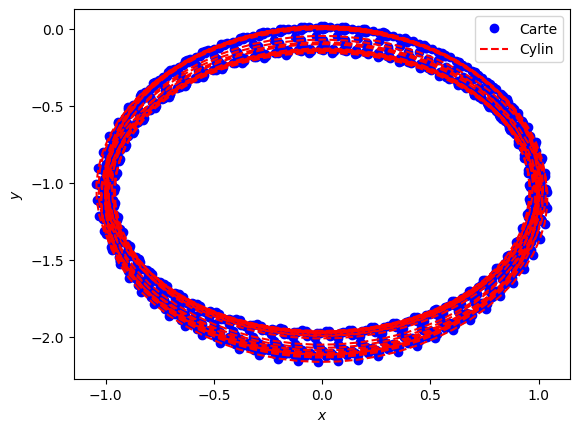

In [14]:
fig, ax1 = plt.subplots()
ax1.plot(CarteX,CarteY,color='blue',linestyle='None',marker='o'   ,label='Carte')
ax1.plot(CylinX,CylinY,color='red' ,linestyle='--'  ,marker='None',label='Cylin')
ax1.set_xlabel('$x$',color='black')
ax1.set_ylabel('$y$',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper right')

plt.savefig('Output/Orbit.jpg', format='jpg')
plt.show()

### 密度输出

In [15]:
t = np.loadtxt('Output/TimeList.dat')

with open('Output/NkValue.dat', 'r') as file:
  lines = file.readlines()

NkS = np.empty(len(lines), dtype=complex)
for i, line in enumerate(lines):
  NkS[i] = complex(line.strip())

In [16]:
from scipy.special import jn

phi0 = -np.pi
fac = np.exp(1j*phi0)

dmu = 0.01
mu = np.arange(0, 8.01, dmu)
Nmu = len(mu)
k_factor = dmu*np.sum(np.exp(-mu)*(1-jn(0,kS*np.sqrt(2*mu))**2))

Nk0 = kS*kS*deltaEne(t)*fac
Nk1 = k_factor*deltaEne(t)*fac

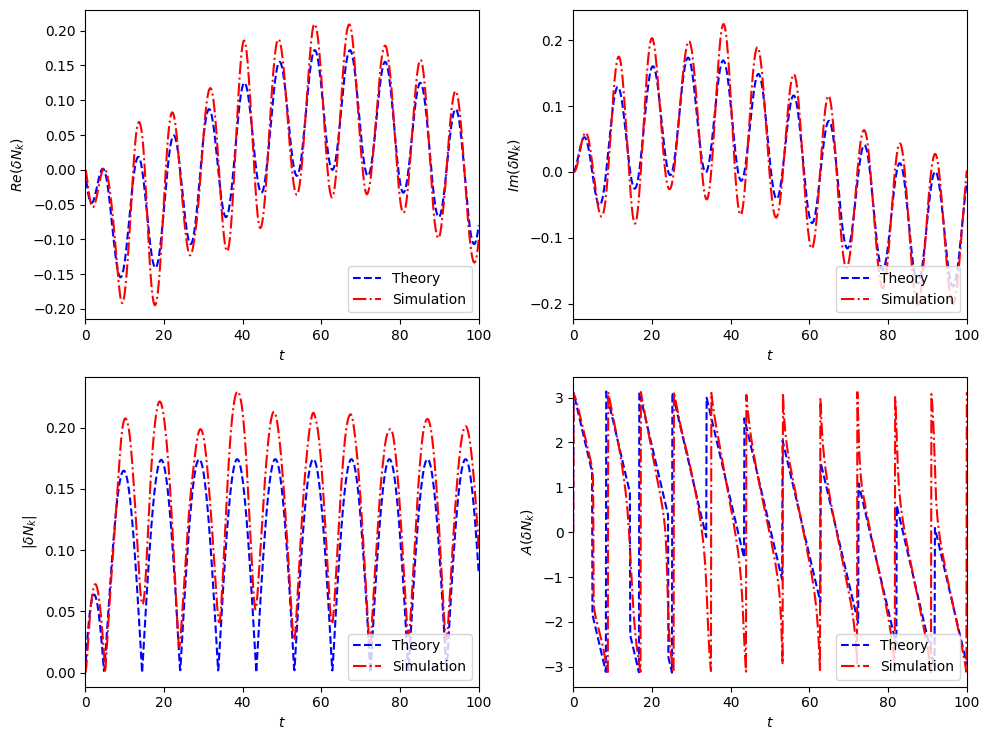

In [17]:
factor = 0.5
PlotTheory0 = False


fig,axes = plt.subplots(2,2,figsize=(20*factor,15*factor))

'Real Part'
Fig = axes[0,0]
if (PlotTheory0):
  Fig.plot( t,np.real(Nk0),color='green', 
            linestyle='-', label='Theory0')
Fig.plot( t,np.real(Nk1),color='blue', 
          linestyle='--',label='Theory')
Fig.plot( t,np.real(NkS),color='red', 
          linestyle='-.',label='Simulation')
Fig.set_xlabel('$t$',color='black')
Fig.set_ylabel('$Re(\delta N_k$)',color='black')
Fig.set_xlim(0,TotalSimTime)
Fig.tick_params(axis='y',color='black')
Fig.legend(loc='lower right')

'Imag Part'
Fig = axes[0,1]
if (PlotTheory0):
  Fig.plot( t,np.imag(Nk0),color='green',
            linestyle='-', label='Theory0')
Fig.plot( t,np.imag(Nk1),color='blue',
          linestyle='--',label='Theory')
Fig.plot( t,np.imag(NkS),color='red',
          linestyle='-.',label='Simulation')
Fig.set_xlabel('$t$', color='black')
Fig.set_ylabel('$Im (\delta N_k)$', color='black')
Fig.set_xlim(0, TotalSimTime)
Fig.tick_params(axis='y', color='black')
Fig.legend(loc='lower right')

'Abs Part'
Fig = axes[1,0]
if (PlotTheory0):
  Fig.plot( t,np.abs(Nk0),color='green', 
            linestyle='-', label='Theory0')
Fig.plot( t,np.abs(Nk1),color='blue', 
          linestyle='--',label='Theory')
Fig.plot( t,np.abs(NkS),color='red', 
          linestyle='-.',label='Simulation')
Fig.set_xlabel('$t$',color='black')
Fig.set_ylabel('$|\delta N_k$|',color='black')
Fig.set_xlim(0,TotalSimTime)
Fig.tick_params(axis='y',color='black')
Fig.legend(loc='lower right')

'Angle Part'
Fig = axes[1,1]
if (PlotTheory0):
  Fig.plot( t,np.angle(Nk0),color='green',
            linestyle='-', label='Theory0')
Fig.plot( t,np.angle(Nk1),color='blue',
          linestyle='--',label='Theory')
Fig.plot( t,np.angle(NkS),color='red',
          linestyle='-.',label='Simulation')
Fig.set_xlabel('$t$', color='black')
Fig.set_ylabel('$A(\delta N_k)$', color='black')
Fig.set_xlim(0, TotalSimTime)
Fig.tick_params(axis='y', color='black')
Fig.legend(loc='lower right')

plt.tight_layout()
plt.savefig('Output/Nk.jpg', format='jpg')
plt.show()